In [1]:
import os

import torch

from src.ddpg import DDPGActor, DDPGCritic, DDPGPolicy, DDPGAgent
from src.pv_env import History, PVEnv
from src.reward import RewardDeltaPower, DiscreteRewardDeltaPower, RewardDeltaPowerVoltage, RewardPower, RewardPowerDeltaPower
from src.ou_noise import OUNoise, GaussianNoise
from src.ddpg import EpsilonDecayLinear
from src.policies import PerturbObservePolicy
from src.experience import ExperienceSorceDiscountedSteps

PV_PARAMS_PATH = os.path.join("parameters", "01_pvarray.json")
WEATHER_TRAIN_PATH = os.path.join("data", "weather_sim.csv")
WEATHER_TEST_PATH = os.path.join("data", "weather_real.csv")
PVARRAY_CKP_PATH = os.path.join('data', '01_pvarray_iv.json')
AGENT_CKP_PATH = os.path.join("models", "06_mppt_ddpg.tar")

In [2]:
env = PVEnv.from_file(
    PV_PARAMS_PATH,
    WEATHER_TRAIN_PATH,
    pvarray_ckp_path=PVARRAY_CKP_PATH,
    # states=["v_norm", "p_norm", 'dv', 'dp'],
    states=["v_norm", "p_norm", 'dv_norm', 'dp_norm'],
    # states=['dv_norm', 'dp_norm', 'g_norm'],
    # states=['g_norm', 't_norm'],
    # reward_fn=RewardDeltaPower(1.05, 1),
    # reward_fn=RewardPower(norm=True),
    reward_fn=RewardPowerDeltaPower(norm=True),
    # v0=25,
)
# test_env = env
test_env = PVEnv.from_file(
    PV_PARAMS_PATH,
    WEATHER_TRAIN_PATH,
    pvarray_ckp_path=PVARRAY_CKP_PATH,
    states=["v_norm", "p_norm", 'dv_norm', 'dp_norm'],
    # states=["v_norm", "i_norm", 'deg'],
    reward_fn=RewardDeltaPower(1.05, 1),
    # reward_fn=RewardDeltaPowerVoltage(1.05, 1, 10),
    v0=12,
)

INFO 2020-11-30 16:42:17,238 Dictionary readed from parameters\01_pvarray.json
INFO 2020-11-30 16:42:17,239 Starting MATLAB engine . . .
INFO 2020-11-30 16:42:47,270 MATLAB engine initializated.
INFO 2020-11-30 16:43:29,970 Model loaded succesfully.
INFO 2020-11-30 16:43:30,027 Dictionary readed from data\01_pvarray_iv.json
INFO 2020-11-30 16:43:30,032 Reading data\weather_sim.csv . . .
INFO 2020-11-30 16:43:30,051 Dictionary readed from parameters\01_pvarray.json
INFO 2020-11-30 16:43:30,052 Starting MATLAB engine . . .
INFO 2020-11-30 16:43:35,640 MATLAB engine initializated.
INFO 2020-11-30 16:44:00,282 Model loaded succesfully.
INFO 2020-11-30 16:44:00,327 Dictionary readed from data\01_pvarray_iv.json
INFO 2020-11-30 16:44:00,331 Reading data\weather_sim.csv . . .


In [3]:
device=torch.device("cpu")
act_net = DDPGActor(
    env.observation_space.shape[0],
    env.action_space.shape[0]
).to(device)
crt_net = DDPGCritic(
    env.observation_space.shape[0],
    env.action_space.shape[0]
).to(device)
agent = DDPGAgent(
    env=env,
    test_env=test_env,
    act_net=act_net,
    crt_net=crt_net,
    # noise=OUNoise(mean=0.0, std=0.1, theta=0.1, dt=1),
    noise=GaussianNoise(mean=0.0, std=0.9),
    eps_schedule=EpsilonDecayLinear(max_steps=50_000,eps_final=0.1),
    device=device,
    gamma=0.8,
    lr=1e-4,
    n_steps=1,
    batch_size=64,
    # chk_path=AGENT_CKP_PATH,
    chk_path=None,
    norm_rewards=False,
    # clip_grads=1e-1,
    clip_grads=-1,
    tau=1e-3,
    crt_lr=1e-3,
)

In [4]:
# takes in a module and applies the specified weight initialization
def weights_init_uniform(m):
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        # apply a uniform distribution to the weights and a bias=0
        m.weight.data.uniform_(0.0, 0.01)
        m.bias.data.fill_(0)

In [5]:
# act_net.apply(weights_init_uniform)
# crt_net.apply(weights_init_uniform)

In [6]:
agent.learn(steps=10000, verbose_every=200, save_every=3_000)

  2%|▏         | 222/10000 [00:02<01:30, 107.48it/s]
 200: loss=-0.375106,  mean reward=nan,  steps/ep=nan,  episodes=0
  4%|▍         | 411/10000 [00:04<01:24, 112.93it/s]
 400: loss=-0.552873,  mean reward=nan,  steps/ep=nan,  episodes=0
  6%|▌         | 615/10000 [00:05<01:20, 116.59it/s]
 600: loss=-0.819741,  mean reward=nan,  steps/ep=nan,  episodes=0
  8%|▊         | 813/10000 [00:07<01:05, 141.14it/s]
 800: loss=-0.794703,  mean reward=99.32,  steps/ep=833,  episodes=1
 10%|█         | 1020/10000 [00:08<01:08, 131.65it/s]
 1000: loss=-0.906473,  mean reward=99.32,  steps/ep=833,  episodes=1
 12%|█▏        | 1215/10000 [00:10<01:07, 130.97it/s]
 1200: loss=-1.098530,  mean reward=99.32,  steps/ep=833,  episodes=1
 14%|█▍        | 1414/10000 [00:11<01:03, 134.68it/s]
 1400: loss=-1.031414,  mean reward=99.32,  steps/ep=833,  episodes=1
 16%|█▌        | 1612/10000 [00:13<01:02, 134.67it/s]
 1600: loss=-1.156464,  mean reward=99.32,  steps/ep=833,  episodes=1
 18%|█▊        | 1822/

In [7]:
agent.policy.epsilon, len(agent.replay_buffer)

(0.79874, 10063)

In [8]:
obs = env.reset()
obs, agent.policy(obs), agent.test_policy(obs), agent.policy.noise.sample()

(array([0.79027356, 0.1518276 , 0.        , 0.        ]),
 array([2.507524], dtype=float32),
 array([1.0864229], dtype=float32),
 -0.5270832958853078)

In [9]:
def compute_reward(history):
    rew = 0
    for s in history:
        rew += s.reward
    return rew

INFO 2020-11-30 16:45:14,557 Calculating true MPP . . .
Calculating true MPP:   8%|8         | 67/834 [00:00<00:01, 668.97it/s]
Reward=177.36044337656278
Calculating true MPP: 100%|##########| 834/834 [00:01<00:00, 722.69it/s]
INFO 2020-11-30 16:45:15,714 Running P&O, step=0.2 volts . . .
Calculating PO: 100%|##########| 834/834 [00:00<00:00, 208452.98it/s]


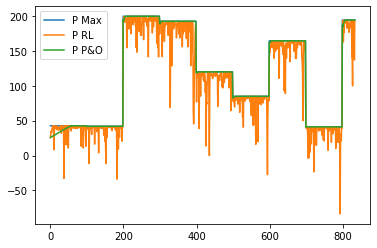

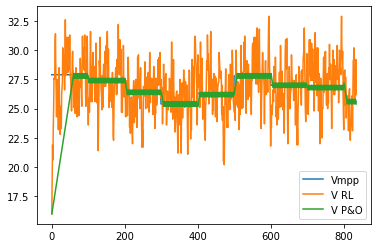

INFO 2020-11-30 16:45:16,370 PO Efficiency=98.55629619759883
INFO 2020-11-30 16:45:16,371 RL Efficiency=89.65038613358215


In [10]:
hist = agent.exp_train_source.play_episode()
rew = compute_reward(hist)
print(f'\nReward={rew}')
env.render_vs_true(po=True)

In [11]:
hist = agent.exp_test_source.play_episode()
rew = compute_reward(hist)
print(f'\nReward={rew}')
test_env.render_vs_true(po=True)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x3 and 4x128)

INFO 2020-11-30 16:41:34,870 Calculating true MPP . . .
Calculating true MPP:  15%|#4        | 122/834 [00:00<00:01, 581.14it/s]
Reward=202.24382749186515
Calculating true MPP: 100%|##########| 834/834 [00:01<00:00, 779.11it/s]


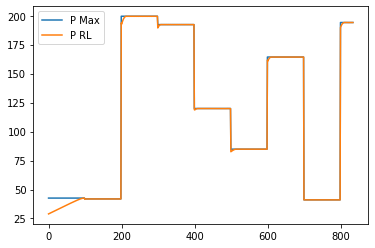

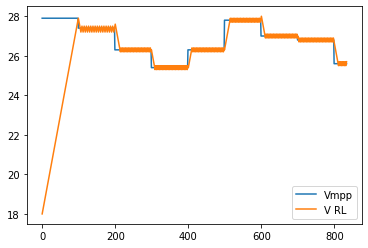

INFO 2020-11-30 16:41:36,471 RL Efficiency=98.1384465732942


In [12]:
po_policy = PerturbObservePolicy(0.1, dv_index=2, dp_index=3)
exp_po_source = ExperienceSorceDiscountedSteps(test_env, po_policy, gamma=0.99, n_steps=1, steps=16)
hist = exp_po_source.play_episode()
rew = compute_reward(hist)
print(f'\nReward={rew}')
test_env.render_vs_true(po=False)

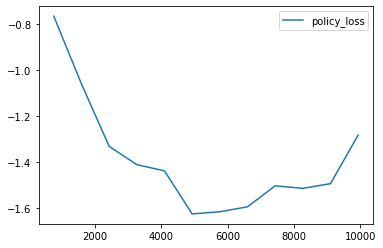

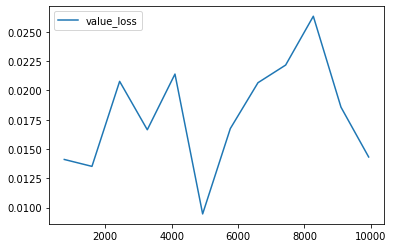

In [13]:
agent.plot_performance(['policy_loss', 'value_loss'])